# CIFAR10 dataset
The CIFAR10 dataset consists of $60,000$ $32\times 32$ images that fall on one of $10$ categories.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

In [2]:
# Device configuration: check if CUDA is available
# My local device does not

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The dataset is first downloaded without applying any transformations such that they have be visually inspected. The first five elements of the training set are shown below. We can see that they are 
1. Frog 
2. Truck
3. Truck
4. Deer
5. Car

In [3]:
dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=None
)

Files already downloaded and verified


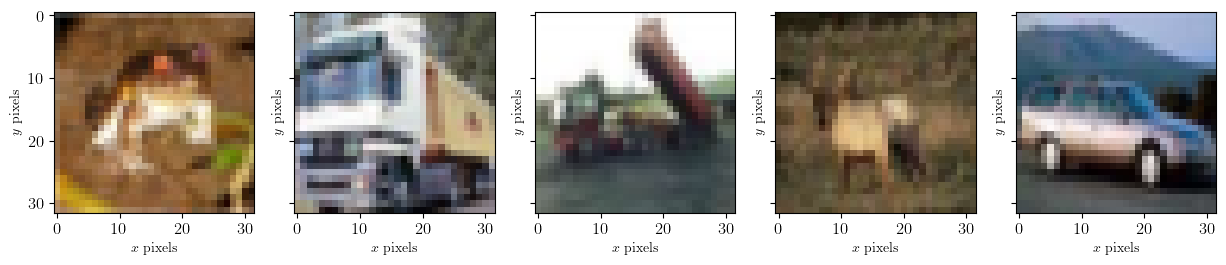

In [4]:
fig, ax = plt.subplots(1, 5, figsize=(15,5), sharey=True)

for i in range(5):
    ax[i].imshow(dataset.data[i])
    ax[i].set_xlabel(r'$x$ pixels')
    ax[i].set_ylabel(r'$y$ pixels')
plt.show()

In [5]:
# Hyper-parameters
learning_rate = 0.001
batch_size = 4

'''
The dataset has PILImage images of range [0, 1]. The dataset is transformed to
tensors of normalized range [-1, 1]
'''

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 3 channels in the CIFAR 10 images
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)


'''
The dateloader objects contain tensors of shape (4 x 3 x 32 x 32) where
4 is the batch_size, 3 is the RGB channel and 32 x 32 are the pixels.
'''

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = {
    '0' : 'airplane',
    '1' : 'automobile',
    '2' : 'bird',
    '3' : 'cat',
    '4' : 'deer',
    '5' : 'dog',
    '6' : 'frog',
    '7' : 'horse',
    '8' : 'ship',
    '9' : 'truck'
}

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
# Effects of normalization

image, label = next(iter(train_loader)) # torchvision transforms are applied to dataloader

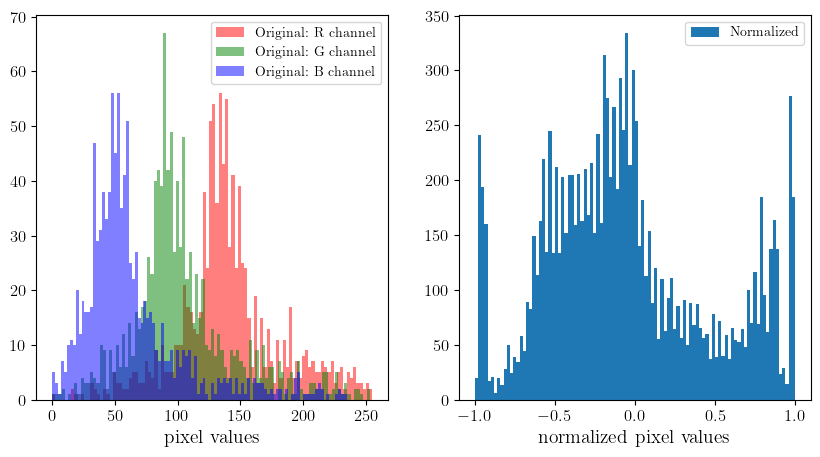

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(train_dataset.data[0][:,:,0].ravel(), bins=100, color='red', alpha=0.5, label='Original: R channel')
ax[0].hist(train_dataset.data[0][:,:,1].ravel(), bins=100, color='green', alpha=0.5, label='Original: G channel')
ax[0].hist(train_dataset.data[0][:,:,2].ravel(), bins=100, color='blue', alpha=0.5, label='Original: B channel')
ax[1].hist(image.ravel(), bins=100, label='Normalized')
ax[0].set_xlabel('pixel values', fontsize=14)
ax[1].set_xlabel('normalized pixel values', fontsize=14)
ax[0].legend()
ax[1].legend()
plt.show()

In [9]:
'''
Implement a convolutional neural network
(1) convolution layer 1 : 3 input channels due to RGB convolved with a 5 x 5 filter to produce 6 output channels
                          resulting image shape is (4 x 6 x 28 x 28)
(2) pooling layer 1     : max pooling layer of size 2 and stride 2; resulting image shape is (4 x 6 x 14 x 14)
(3) convolution layer 2 : 6 input channels from 1st convolution layer with the same 5 x 5 filter to produce 16 output channels
                        : resulting image shape is (4 x 16 x 10 x 10)
(4) pooling layer 2     : max pooling layer of size 2 and stride 2; resulting image shape is (4 x 16 x 5 x 5)
The total number of features after the 2nd pooling layer is 16 x 5 x 5 = 400
'''

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool1( F.relu(self.conv1(x)) ) # 1st convolution and pooling layers
        x = self.pool2( F.relu(self.conv2(x)) ) # 2nd convolution and pooling layers
        x = x.view(-1, 16*5*5) # Flattened image tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # no need to apply softmax activation since Cross Entropy applies it

        return x

In [19]:
'''  
Using the Cross Entropy loss function and Stochastic Gradient Descent optimizer
'''
model = ConvNet().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

def train(dataloader, model, loss_fn, optimizer, num_epochs):
    size = len(dataloader.dataset)
    batch_size = len(dataloader)
    loss_train = np.zeros(num_epochs) # Loss history per epoch during training
    acc_train = np.zeros(num_epochs) # Accuracy history per epoch during training
   
    model.train()
    
    for epoch in range(num_epochs):
        running_correct = 0 # Keeps track of the number of correct classifications
        running_total = 0
        for i, (image, label) in enumerate(dataloader):
            image, label = image.to(device), label.to(device)
            
            '''  
            Calculate prediction and loss function per epoch
            '''
            label_pred = model(image)
            loss = loss_fn(label_pred, label)
            ''' 
            Backpropagating the loss function to re-adjust weights
            '''
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train[epoch] += loss.item()*image.size(0) # Accumulated loss per training batch
            _, predicted = torch.max(label_pred, 1)
            running_total += label.size(0)
            running_correct += (predicted == label).sum().item()

            if (i + 1) % 2500 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{batch_size}], Loss: {loss:.4f}, Accuracy: {running_correct/running_total:.4f}')

        loss_train[epoch] = loss_train[epoch]/size
        acc_train[epoch] = running_correct/running_total # Proportion of accurate predictions      
    
    return loss_train, acc_train

In [20]:
loss, accuracy = train(train_loader, model, loss_fn, optimizer, num_epochs=5)

Epoch [1/5], Step [2500/12500], Loss: 1.8754,                        Accuracy: 0.1800
Epoch [1/5], Step [5000/12500], Loss: 1.6252,                        Accuracy: 0.2383
Epoch [1/5], Step [7500/12500], Loss: 1.1321,                        Accuracy: 0.2880
Epoch [1/5], Step [10000/12500], Loss: 1.3384,                        Accuracy: 0.3243
Epoch [1/5], Step [12500/12500], Loss: 2.5783,                        Accuracy: 0.3509
Epoch [2/5], Step [2500/12500], Loss: 1.9123,                        Accuracy: 0.4849
Epoch [2/5], Step [5000/12500], Loss: 1.5334,                        Accuracy: 0.4905
Epoch [2/5], Step [7500/12500], Loss: 0.8605,                        Accuracy: 0.4994
Epoch [2/5], Step [10000/12500], Loss: 1.7243,                        Accuracy: 0.5049
Epoch [2/5], Step [12500/12500], Loss: 1.4332,                        Accuracy: 0.5094
Epoch [3/5], Step [2500/12500], Loss: 0.3948,                        Accuracy: 0.5567
Epoch [3/5], Step [5000/12500], Loss: 0.9335,     

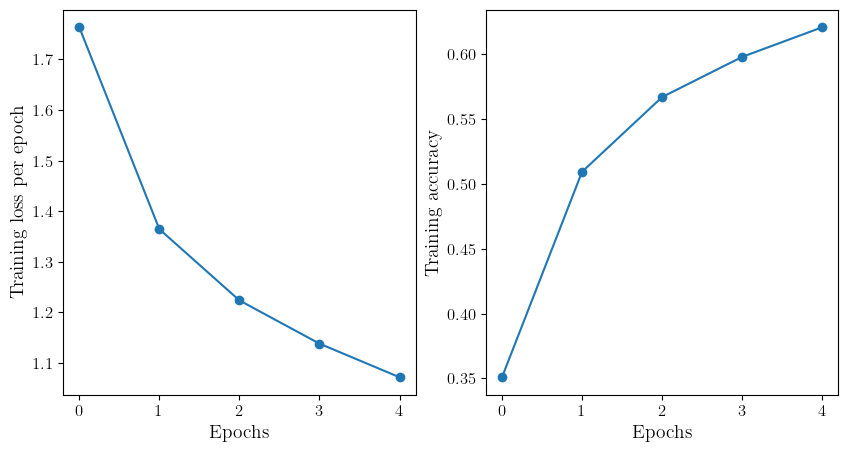

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(loss, 'o-')
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Training loss per epoch', fontsize=14)

ax[1].plot(accuracy, 'o-')
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Training accuracy', fontsize=14)

plt.show()

In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 59 %
